# 使用Titanic乘客信息
1. 自动从网络（或者本地）获取源信息
2. 使用Pandas对数据进行整理，做成dataframe的形式（相当于一条一条的tensor，每一行是一个tensor）
3. 构建简易的训练模型
4. 进行训练
5. 保存模型到model文件夹

In [1]:
import sys
import urllib.request
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers



 1. 获取源信息

In [2]:
'''如果本地没有数据集，则从服务器上拉取'''
filePath='./data/titanic.xls'
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls'
if not os.path.isfile(filePath):
    result=urllib.request.urlretrieve(url,filePath)
    print('success download:'+result)
print('data input success')

data input success


In [3]:
cols=[
    'pclass','survived','name',	'sex','age','sibsp',
    'parch','ticket','fare','cabin','embarked',	
    'boat',	'body',	'home.dest'
]#the name of every column

excel=pd.read_excel(filePath)#open the source

'''separate the source excel into train and test'''
dftrain_raw=excel[0:1000]
dftest_raw=excel[1000:]

#Show the separated source 
#print(dftest_raw.head(5))
#print(dftrain_raw.head(5))#the source for train

In [4]:
dftrain_raw=dftrain_raw.drop(['name','ticket'],axis=1)#丢弃 ‘ticket’这一列
dftest_raw=dftest_raw.drop(['name','ticket'],axis=1)

#Show the source after dropped determine columns
#print(dftrain_raw.head(5))
#print(dftest_raw.head(5))

pclass         0
survived       0
sex            0
age          139
sibsp          0
parch          0
fare           0
cabin        717
embarked       2
boat         583
body         905
home.dest    258
dtype: int64
0    577
1    423
Name: survived, dtype: int64


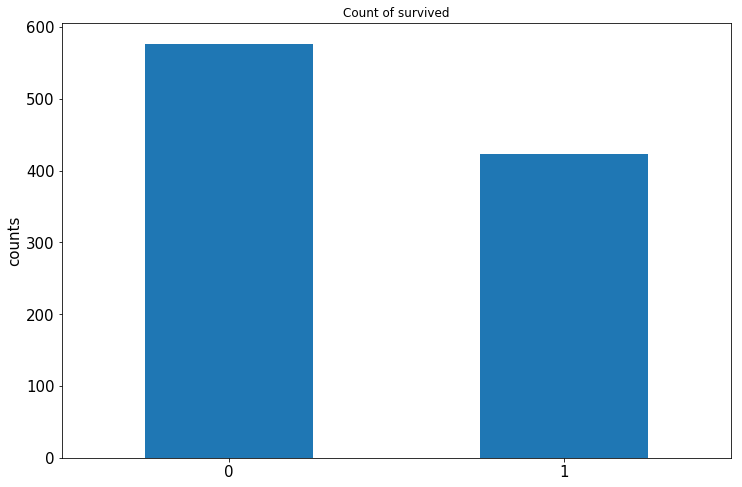

In [5]:
print(dftrain_raw.isnull().sum())#每一列中的空cell的个数
print(dftrain_raw['survived'].value_counts())
draft=dftrain_raw['survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
draft.set_title('Count of survived')
draft.set_ylabel('counts',fontsize=15)
plt.show()

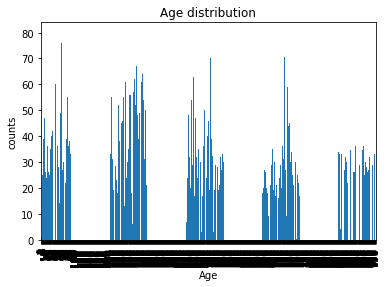

In [6]:
'''Paint the distribution of age'''
draft=dftrain_raw['age'].plot(kind='bar')
#draft=dftrain_raw['age'].plot( kind='hist',figsize=(12,8),bins=20,color='green', fontsize=15,rot=0)
draft.set_title('Age distribution')
draft.set_ylabel('counts')
draft.set_xlabel('Age')
plt.show()

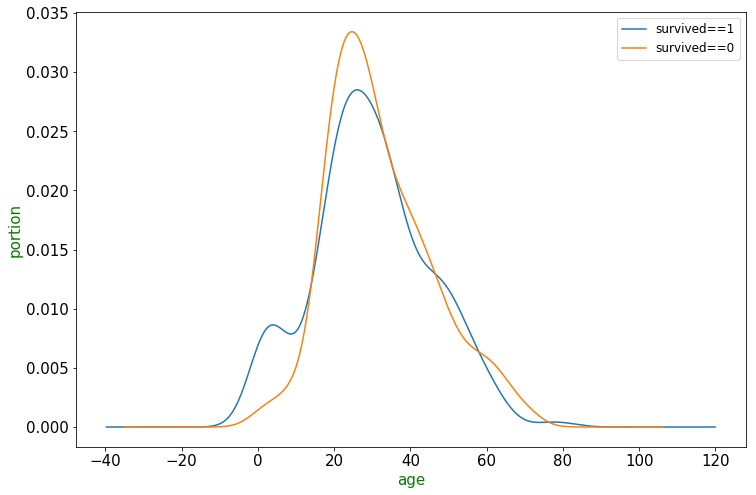

Age distribution of survived and not survived


In [7]:
#把存活和不存活的人的age全部获取，把序列画在图（age_sur_die代表图的索引）上,在图中画出存活者年龄分布的密度（占比）
#dftrain_raw.query('survived==1')['age']#查询符合条件‘survived==1’的年龄，返回的是一个一维序列
age_sur_die=dftrain_raw.query('survived==1')['age'].plot( kind='density',figsize=(12,8),fontsize=15)
dftrain_raw.query('survived==0')['age'].plot( kind='density',figsize=(12,8),fontsize=15)
age_sur_die.set_xlabel('age',fontsize=15,color='green')
age_sur_die.set_ylabel('portion',fontsize=15,color='green')
age_sur_die.legend(['survived==1','survived==0'],fontsize = 12)
plt.show()
print('Age distribution of survived and not survived')


## Process the source into dataframe
- process function

In [8]:
def process(dfdata):
    
    dfresult=pd.DataFrame()
    '''get_dummies is to make the data to binary and sort in group'''
    '''such as 
    pclass_A pclass_B pclass_C
    1           0       0
    0           0       1
    1           0       0
    0           1       0
    every row represent one object's attribute
    '''
    #dfPclass
    #dfPclass=pd.DataFrame()
    #print(pd.get_dummies(dfdata['pclass']))
    dfPclass=pd.get_dummies(dfdata['pclass'])
    
    #print(dfPclass.shape)
   
    '''
    Here is to sovle the x_test has only one column of 'pclass',
    so append two blank columns for it.
    '''
    tempdfpclass=pd.DataFrame(data={'A':[],'B':[]})
    if dfPclass.shape[1]<pd.get_dummies(excel['pclass']).shape[1]:
       i=1
       while i<pd.get_dummies(excel['pclass']).shape[1]-dfPclass.shape[1]-1 :
           tempdfpclass=pd.concat([tempdfpclass,tempdfpclass],axis=1)
           i=i+1
       dfPclass=pd.concat([tempdfpclass,dfPclass],axis=1)
    #print(tempdfpclass.shape)
    
    dfPclass.columns = ['pclass_' +str(x) for x in  pd.get_dummies(excel['pclass']).columns]
    
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)
    dfresult['pclass_1']=dfresult['pclass_1'].fillna(0)
    dfresult['pclass_2']=dfresult['pclass_2'].fillna(0)
    
    #sex
    dfsex=pd.get_dummies(dfdata['sex'])
    #dfresult=pd.concat([dfresult,dfsex],axis=0)#concat the frame up and down 
    dfresult=pd.concat([dfresult,dfsex],axis=1)#concat the frame left and right
    
    #age feature (type:int32)(copy from the dfdata)
    dfresult['age']=dfdata['age'].fillna(0)#fill 0 when it is na(empty)
    dfresult['age_null']=dfdata['age'].isnull().astype('int32')
    
     #SibSp,Parch,Fare
    dfresult['sibsp'] = dfdata['sibsp']
    dfresult['parch'] = dfdata['parch']
    dfresult['fare'] = dfdata['fare']

    #carbin
    #add the feature of 'is the cabin empty?'
    dfresult['cabin_null']=pd.isnull(dfdata['cabin']).astype('int32')
    
    #embarked
    dfembarked=pd.get_dummies(dfdata['embarked'],dummy_na=True)
    dfembarked.columns=['embark_'+str(x) for x in dfembarked.columns]
    dfresult=pd.concat([dfresult,dfembarked],axis=1)
    return (dfresult)

- Call 'process' to transform source 

In [9]:
x_train=process(dftrain_raw)
y_train=dftrain_raw['survived'].values


x_test=process(dftest_raw)
y_test=dftest_raw['survived'].values

print("x_train.shape =", x_train.shape)
print('columns of x_train:',x_train.columns)

print("x_test.shape =", x_test.shape)
print('columns of x_test:',x_test.columns)

#print(x_train)
#print(x_test)
#print(excel)

x_train.shape = (1000, 15)
columns of x_train: Index(['pclass_1', 'pclass_2', 'pclass_3', 'female', 'male', 'age', 'age_null',
       'sibsp', 'parch', 'fare', 'cabin_null', 'embark_C', 'embark_Q',
       'embark_S', 'embark_nan'],
      dtype='object')
x_test.shape = (309, 15)
columns of x_test: Index(['pclass_1', 'pclass_2', 'pclass_3', 'female', 'male', 'age', 'age_null',
       'sibsp', 'parch', 'fare', 'cabin_null', 'embark_C', 'embark_Q',
       'embark_S', 'embark_nan'],
      dtype='object')


- Construct model

In [11]:
tf.keras.backend.clear_session()
model=models.Sequential()
model.add(layers.Dense(20,activation='relu',input_shape=(15,)))
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


- Train model

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['AUC'])
history=model.fit(x_train,y_train,batch_size=64,epochs=30,validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 2s 2ms/sample - loss: 2.7053 - AUC: 0.4043 - val_loss: 0.6507 - val_AUC: 0.5170
Epoch 2/30
800/800 [==============================] - 0s 74us/sample - loss: 1.3797 - AUC: 0.4391 - val_loss: 0.6399 - val_AUC: 0.4603
Epoch 3/30
800/800 [==============================] - 0s 56us/sample - loss: 0.8841 - AUC: 0.5097 - val_loss: 0.7040 - val_AUC: 0.4330
Epoch 4/30
800/800 [==============================] - 0s 52us/sample - loss: 0.7786 - AUC: 0.5579 - val_loss: 0.6974 - val_AUC: 0.4534
Epoch 5/30
800/800 [==============================] - 0s 69us/sample - loss: 0.7516 - AUC: 0.6123 - val_loss: 0.68

- Access model

In [ ]:
import matplotlib.pyplot as plt